# Compare grids of gcmx and 60km vorticity@850 and pr

In [48]:
%reload_ext autoreload

%autoreload 2

import math
import os

import iris
import iris.analysis.cartography
import matplotlib
import matplotlib.pyplot as plt
import xarray as xr

import ml_downscaling_emulator as mlde
from ml_downscaling_emulator.utils import cp_model_rotated_pole, platecarree, plot_grid, precip_cmap, precip_norm

In [63]:
DOMAIN="birmingham"
FREQUENCY="day"
YEAR=1981

def open_ds(resolution, variable):
    ds_meta = mlde.UKCPDatasetMetadata(os.getenv("MOOSE_DERIVED_DATA"), resolution=resolution, variable=variable, frequency=FREQUENCY, domain=DOMAIN)
    try:
        ds = xr.open_dataset(ds_meta.filepath(YEAR)).isel(time=0)
    except FileNotFoundError:
        return None
    return ds

In [66]:
RESOLUTIONS = [
    "2.2km-coarsened-gcm-2.2km-coarsened-4x-bad-grid",
    "2.2km-coarsened-gcm-2.2km-coarsened-4x",
    "60km-2.2km-coarsened-4x"
]
VARIABLES=["vorticity850", "pr"]

datasets = {var: {res: open_ds(res, var) for res in RESOLUTIONS} for var in VARIABLES}

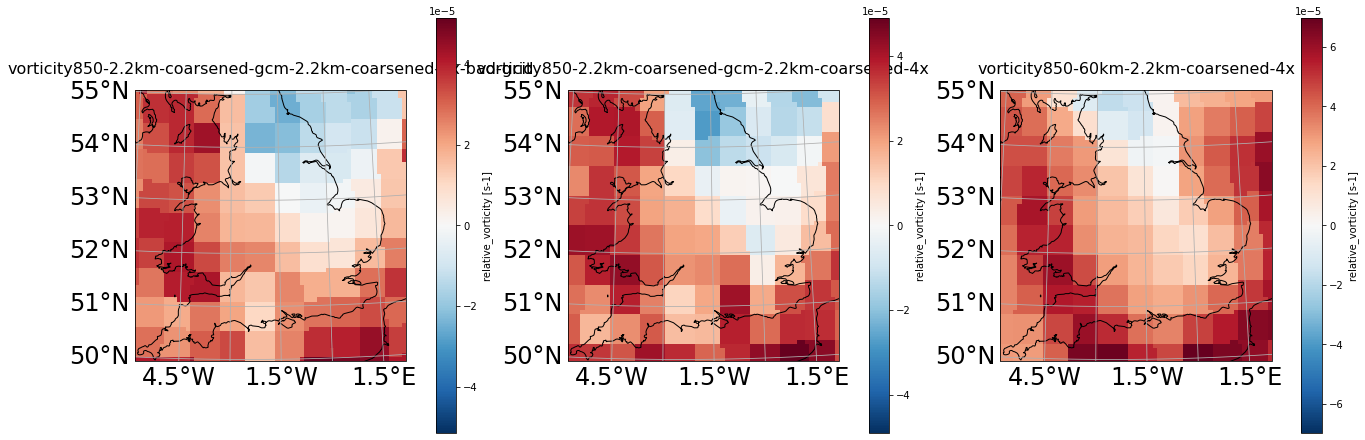

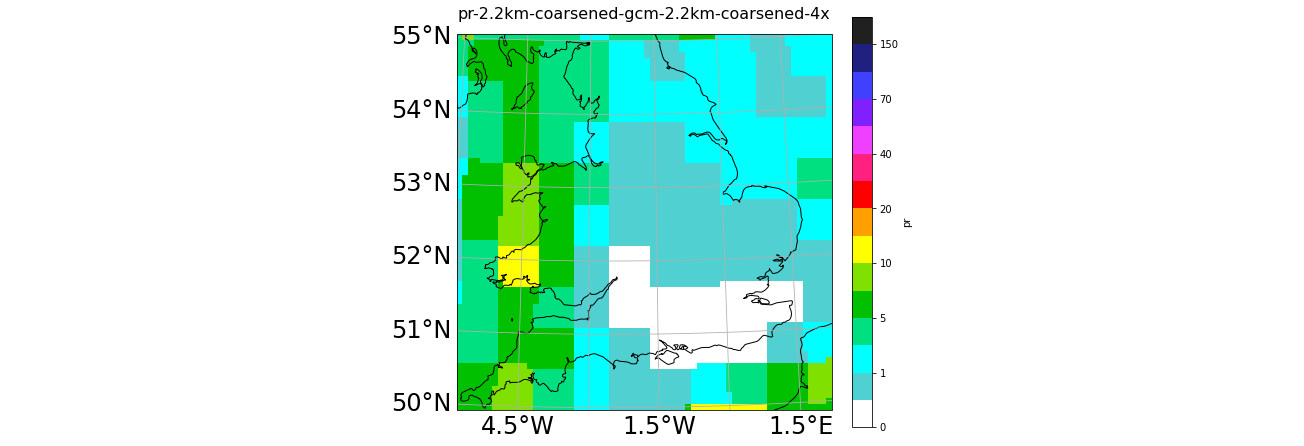

In [67]:
var = "vorticity850"
fig, axd = plt.subplot_mosaic([RESOLUTIONS], figsize=(18, 6), constrained_layout=True, subplot_kw={'projection': cp_model_rotated_pole})
for res in RESOLUTIONS: 
    ax = axd[res]
    plot_grid(datasets[var][res][var], ax=ax, center=0, add_colorbar=True, style=None, title=f"{var}-{res}")

var = "pr"
fig, axd = plt.subplot_mosaic([RESOLUTIONS], figsize=(18, 6), constrained_layout=True, subplot_kw={'projection': cp_model_rotated_pole})
for res in RESOLUTIONS: 
    ax = axd[res]
    ds = datasets[var][res]
    if ds is not None:
        plot_grid(ds[var]*3600*24, ax=ax, add_colorbar=True, style="precip", title=f"{var}-{res}")
    else:
        ax.axis('off')

In [89]:
datasets["vorticity850"]["2.2km-coarsened-gcm-2.2km-coarsened-4x"]["vorticity850"].isel(grid_latitude=32).isel(grid_longitude=[3,4]).values

array([3.36134344e-05, 3.53252294e-05])

In [88]:
datasets["vorticity850"]["2.2km-coarsened-gcm-2.2km-coarsened-4x-bad-grid"]["vorticity850"].isel(grid_latitude=32).isel(grid_longitude=[3,4]).values

array([3.97101338e-05, 3.97101338e-05])

The hi-res grid this data is shown on is the same.
**However, can see that the coarse grid of underlying data are a bit offset from each other** even though they should be the same.
This has now been fixed by having a vorticity specific global 60km grid since winds are on a different grid to precip

## MOOSE data

In [7]:
moose_datasets = {var: xr.open_dataset(f"../../scratch/gcm-{var}-dec1980.nc").isel(time=slice(2)) for var in ["xwind", "ywind", "pr"]}

In [32]:
moose_datasets["xwind"]["x_wind"].isel(time=0, pressure=0).shape, moose_datasets["ywind"]["y_wind"].isel(time=0, pressure=0).shape, moose_datasets["pr"]["precipitation_flux"].isel(time=0).shape

((325, 432), (325, 432), (324, 432))

In [36]:
np.all(moose_datasets["xwind"]["longitude"].values == moose_datasets["pr"]["longitude"].values)

False

In [46]:
np.all(moose_datasets["xwind"]["longitude"].values == moose_datasets["ywind"]["longitude"].values)

True

In [47]:
np.all(moose_datasets["xwind"]["latitude"].values == moose_datasets["ywind"]["latitude"].values)

True

Precip and wind grids have different latitude coordinates (down to having a different number of them) and different longitude as well. But winds do at least seem to have the same grid (in GCM).

In [34]:
moose_datasets["pr"]["latitude"].values

array([-89.72222   , -89.166664  , -88.61111   , -88.05556   ,
       -87.5       , -86.94444   , -86.388885  , -85.833336  ,
       -85.27778   , -84.72222   , -84.166664  , -83.61111   ,
       -83.05556   , -82.5       , -81.94444   , -81.388885  ,
       -80.83333   , -80.27778   , -79.72222   , -79.166664  ,
       -78.61111   , -78.05556   , -77.5       , -76.94444   ,
       -76.388885  , -75.83333   , -75.27778   , -74.72222   ,
       -74.166664  , -73.61111   , -73.05556   , -72.5       ,
       -71.94444   , -71.388885  , -70.83333   , -70.27778   ,
       -69.72222   , -69.166664  , -68.61111   , -68.05556   ,
       -67.5       , -66.94444   , -66.388885  , -65.83333   ,
       -65.27777   , -64.72222   , -64.166664  , -63.611107  ,
       -63.055553  , -62.5       , -61.944443  , -61.388885  ,
       -60.833332  , -60.277775  , -59.72222   , -59.166664  ,
       -58.611107  , -58.055553  , -57.499996  , -56.944443  ,
       -56.388885  , -55.833332  , -55.277775  , -54.72

In [33]:
moose_datasets["xwind"]["latitude"].values

array([-9.00000000e+01, -8.94444427e+01, -8.88888855e+01, -8.83333359e+01,
       -8.77777786e+01, -8.72222214e+01, -8.66666641e+01, -8.61111145e+01,
       -8.55555573e+01, -8.50000000e+01, -8.44444427e+01, -8.38888855e+01,
       -8.33333359e+01, -8.27777786e+01, -8.22222214e+01, -8.16666641e+01,
       -8.11111145e+01, -8.05555573e+01, -8.00000000e+01, -7.94444427e+01,
       -7.88888855e+01, -7.83333359e+01, -7.77777786e+01, -7.72222214e+01,
       -7.66666641e+01, -7.61111145e+01, -7.55555573e+01, -7.50000000e+01,
       -7.44444427e+01, -7.38888855e+01, -7.33333282e+01, -7.27777786e+01,
       -7.22222214e+01, -7.16666641e+01, -7.11111145e+01, -7.05555573e+01,
       -7.00000000e+01, -6.94444427e+01, -6.88888855e+01, -6.83333282e+01,
       -6.77777786e+01, -6.72222214e+01, -6.66666641e+01, -6.61111145e+01,
       -6.55555573e+01, -6.50000000e+01, -6.44444427e+01, -6.38888855e+01,
       -6.33333321e+01, -6.27777786e+01, -6.22222214e+01, -6.16666641e+01,
       -6.11111107e+01, -

In [38]:
moose_datasets["xwind"]

<xarray.Dataset>
Dimensions:                  (time: 2, pressure: 2, latitude: 325,
                              longitude: 432, bnds: 2)
Coordinates:
  * time                     (time) object 1980-12-01 12:00:00 1980-12-02 12:...
  * pressure                 (pressure) float32 20.0 850.0
  * latitude                 (latitude) float32 -90.0 -89.44 ... 89.44 90.0
  * longitude                (longitude) float32 0.0 0.8333 ... 358.3 359.2
    forecast_period          (time) timedelta64[ns] ...
    forecast_reference_time  object ...
    realization              int32 ...
Dimensions without coordinates: bnds
Data variables:
    x_wind                   (time, pressure, latitude, longitude) float32 ...
    latitude_longitude       int32 ...
    time_bnds                (time, bnds) object ...
    forecast_period_bnds     (time, bnds) float64 ...
Attributes:
    source:       Data from Met Office Unified Model
    um_version:   10.4
    Conventions:  CF-1.7

In [43]:
ds = moose_datasets["xwind"].reset_coords(["forecast_period", "forecast_reference_time", "realization"], drop=True).drop_vars(["forecast_period_bnds"])
for v in ds.variables:
    print(v, ds[v].encoding.pop("coordinates", None))

x_wind forecast_period forecast_reference_time realization
latitude_longitude None
time None
time_bnds None
pressure None
latitude None
longitude None


In [44]:
ds


<xarray.Dataset>
Dimensions:             (time: 2, pressure: 2, latitude: 325, longitude: 432,
                         bnds: 2)
Coordinates:
  * time                (time) object 1980-12-01 12:00:00 1980-12-02 12:00:00
  * pressure            (pressure) float32 20.0 850.0
  * latitude            (latitude) float32 -90.0 -89.44 -88.89 ... 89.44 90.0
  * longitude           (longitude) float32 0.0 0.8333 1.667 ... 358.3 359.2
Dimensions without coordinates: bnds
Data variables:
    x_wind              (time, pressure, latitude, longitude) float32 ...
    latitude_longitude  int32 -2147483647
    time_bnds           (time, bnds) object 1980-12-01 00:00:00 ... 1980-12-0...
Attributes:
    source:       Data from Met Office Unified Model
    um_version:   10.4
    Conventions:  CF-1.7